This Jupyter Notebook contains code to do the following:
- ff

The notebook is divided into sections and each code block is suplemented with comments and markdown text to guide the user about whats going on.

All or parts of the code from this notebook can be easily copied to create standalone python script files.
Further information about the methods used in this notebook can be found in the following papers:
- https://arxiv.org/abs/2511.12685
- 


# Initialization

In [2]:
# importing necessary libraries
import os
import sys
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from src.configManager import ConfigManager
import xarray as xr

config = ConfigManager()

In [3]:
# code to set up matplotlib and seaborn styles

plt.style.use('default')

# Save the default rcParams to revert back if needed
dflt_rcParams = mpl.rcParams.copy()

# Change the default font
mpl.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': ['Arial']})

# Increase the font size for better readability
mpl.rcParams.update({'font.size': 14, 
                     'axes.titlesize': 14,
                     'axes.titleweight': 'bold', 
                     'axes.labelsize': 12,
                     'axes.labelweight': 'bold',
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12, 
                     'legend.fontsize': 11})

# Remove the top and right spines for a cleaner look
mpl.rcParams.update({'axes.spines.right': False, 
                     'axes.spines.top': False,
                     'axes.spines.left': True,
                     'axes.spines.bottom': True})

# Add space between the plot and the title
mpl.rcParams.update({'axes.titlepad': 15})

# Set the figure size for all plots
mpl.rcParams.update({'figure.figsize': (10, 6)})

# Set the style for seaborn
sns.set_style("white")  # other options: "dark", "whitegrid", "darkgrid", "ticks"

In [4]:
state = config.get('processing_parameters')['state']
county = config.get('processing_parameters')['county']
start_year = config.get('processing_parameters')['start_year']
end_year = config.get('processing_parameters')['end_year']

ds_merged = xr.open_dataset(os.path.join(
    config.get("data_paths.merged_data_dir"),
    state,
    config.get("file_patterns.merged_file_pattern").format(
        state=state,
        county=county,
        start=start_year,
        end=end_year
    )
))  

# Exploring the Merged Data

In [5]:
# check the different details of the dataset in an interactive viewer
ds_merged

<xarray.Dataset> Size: 25MB
Dimensions:              (time: 385728, station: 2)
Coordinates:
  * time                 (time) datetime64[ns] 3MB 2014-01-01 ... 2024-12-31T...
  * station              (station) <U3 24B 'CLM' 'UIL'
    lat                  (station) <U7 56B ...
    lon                  (station) <U9 72B ...
Data variables:
    tmpf                 (time, station) float32 3MB ...
    sknt                 (time, station) float32 3MB ...
    gust                 (time, station) float32 3MB ...
    p01i                 (time, station) float32 3MB ...
    poccurence           (time, station) float32 3MB ...
    customers_out        (time) int64 3MB ...
    event_number_eaglei  (time) int64 3MB ...
Attributes:
    title:                   Merged Weather and Outage Data for Clallam, Wash...
    description:             This dataset contains weather data from multiple...
    state:                   Washington
    county:                  Clallam
    start_year:              2014
    end_year:                2024
    creation_date:           2026-01-21 11:43:57
    temporal_resolution:     15 minutes
    county_fips_code:        53009
    total_county_customers:  45459

In [6]:
# get the timeseries range of the merged dataset
print(ds_merged['time'].values[0], ds_merged['time'].values[-1])

2014-01-01T00:00:00.000000000 2024-12-31T23:45:00.000000000


In [7]:
# get all the variables in the dataset
print(ds_merged.data_vars)

Data variables:
    tmpf                 (time, station) float32 3MB ...
    sknt                 (time, station) float32 3MB ...
    gust                 (time, station) float32 3MB ...
    p01i                 (time, station) float32 3MB ...
    poccurence           (time, station) float32 3MB ...
    customers_out        (time) int64 3MB ...
    event_number_eaglei  (time) int64 3MB ...


In [8]:
# get all the stations available in the merged dataset
print(ds_merged['station'].values)

['CLM' 'UIL']


In [9]:
# get all the data for a specific station, e.g., 'MIA'
station='CLM'
ds_merged.sel(station=station)

<xarray.Dataset> Size: 17MB
Dimensions:              (time: 385728)
Coordinates:
  * time                 (time) datetime64[ns] 3MB 2014-01-01 ... 2024-12-31T...
    station              <U3 12B 'CLM'
    lat                  <U7 28B ...
    lon                  <U9 36B ...
Data variables:
    tmpf                 (time) float32 2MB ...
    sknt                 (time) float32 2MB ...
    gust                 (time) float32 2MB ...
    p01i                 (time) float32 2MB ...
    poccurence           (time) float32 2MB ...
    customers_out        (time) int64 3MB ...
    event_number_eaglei  (time) int64 3MB ...
Attributes:
    title:                   Merged Weather and Outage Data for Clallam, Wash...
    description:             This dataset contains weather data from multiple...
    state:                   Washington
    county:                  Clallam
    start_year:              2014
    end_year:                2024
    creation_date:           2026-01-21 11:43:57
    temporal_resolution:     15 minutes
    county_fips_code:        53009
    total_county_customers:  45459

In [10]:
# select all values of a particular weather variable at a specific time (for all stations in the dataset in order)
print(ds_merged['tmpf'].sel(time='2020-06-15 12:00:00').values)

[51. 50.]


In [11]:
# select a particular weather variable for a specific station at a specific time
print(ds_merged['tmpf'].sel(station=station, time='2020-06-15 12:00:00').values)

51.0


In [12]:
ds_merged['customers_out'].sel(time='2020-06-15 12:00:00').values

array(0)

In [13]:
# Select time range and get all data
data = ds_merged.sel(time=slice('2021-06-27', '2021-06-28'))

# Access weather from specific station
station_weather = data.sel(station=station)

# Access outage data for the time period
outages = data['customers_out']

In [14]:
outages.values

array([    2,     2,     2,     1,     1,     1,     1,     1,     1,
           1,  7561,  8917,  8917, 11455, 12138, 10448,   151,    42,
          44,    43,    43,    43,    43,    43,    43,    43,    43,
          42,    42,    42,    42,    42,    42,    42,    42,    42,
          42,    42,    42,    42,    42,    42,    42,    42,    42,
          42,    42,    42,    42,    42,    42,    42,    42,    42,
          42,    42,    42,    42,    42,    42,    42,    42,    42,
          42,    42,    42,    42,    42,    42,    42,    42,    42,
          42,    42,    42,    42,    42,    42,    42,    42,    42,
          42,    42,    42,    42,    42,    42,    44,    44,    56,
          56,    56,    56,    56,    56,    56,    56,    56,    56,
          56,    56,    56,    56,    56,    56,    56,    56,    56,
          56,    56,    56,    56,    56,    56,    56,    56,    56,
          56,    56,    56,    56,    56,    56,    56,    56,    56,
          56,    42,

# Analyzing Events in the EAGLE-I Outage Data

In [15]:
# create a dataframe of customers_out and event_number_eaglei from the xarray dataset
outage_df = ds_merged[['customers_out', 'event_number_eaglei']].to_dataframe().reset_index()
print(f"Size of the outage dataframe: {outage_df.shape}")
# keep only rows where customers_out > 0
outage_df = outage_df[outage_df['customers_out'] > 0]
print(f"Size of the outage dataframe after filtering customers_out > 0: {outage_df.shape}")

Size of the outage dataframe: (385728, 3)
Size of the outage dataframe after filtering customers_out > 0: (89840, 3)


In [16]:
outage_df.head()

,time,customers_out,event_number_eaglei
186914,2019-05-02 00:30:00,1,1
186915,2019-05-02 00:45:00,1,1
186916,2019-05-02 01:00:00,1,1
186917,2019-05-02 01:15:00,1,1
186918,2019-05-02 01:30:00,1,1


In [17]:
# Total number of outage events
print(f"Total number of outage events: {outage_df['event_number_eaglei'].nunique()}")
# Total number of outage events, excluding the ones that don't meet the customers_out threshold
customers_out_threshold = config.get('data_cleaning_parameters')['events_customer_threshold']
print(f"Total number of outage events (customers_out > {customers_out_threshold}): {outage_df[outage_df['customers_out'] >= customers_out_threshold]['event_number_eaglei'].nunique()}")

Total number of outage events: 2837
Total number of outage events (customers_out > 30): 509


In [18]:
# Size of the top 10 longest outage events (longest in terms of number of records)
# Since each record represents a 15-minute interval, it is a proxy for duration
print(outage_df.groupby('event_number_eaglei')
                          .size()
                          .sort_values(ascending=False)
                          .head(10))

event_number_eaglei
1580    1056
76       961
1575     686
1261     501
889      497
1577     494
1179     489
1998     483
727      480
1456     453
dtype: int64


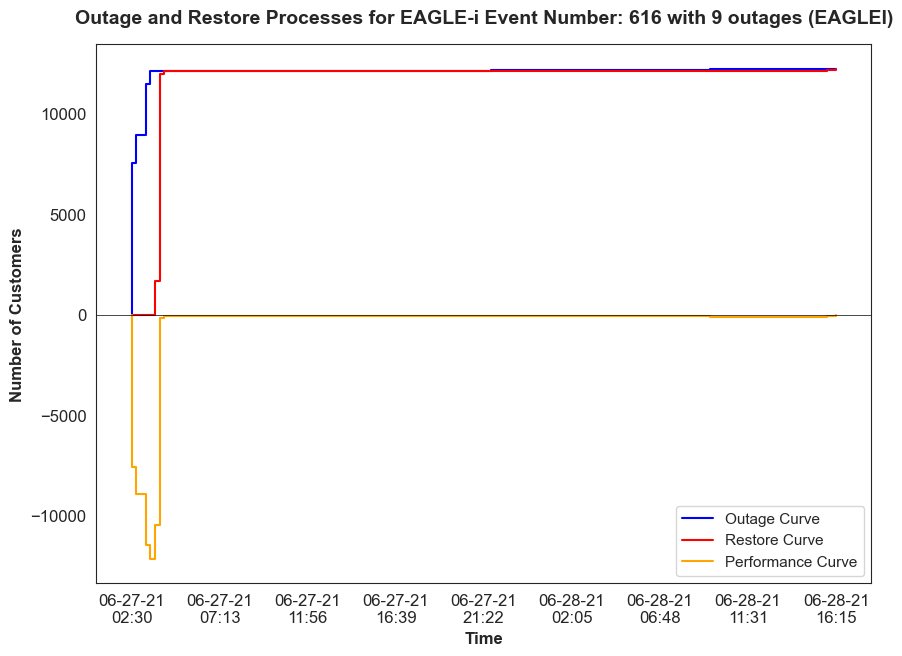

In [19]:
from src.eaglei_modules.eagleiEventProcessing import plot_eaglei_event_curves
plot_eaglei_event_curves(outage_df, event_number=616, event_method='eaglei', timestamp_column='time')

# Analyzing Weather Data

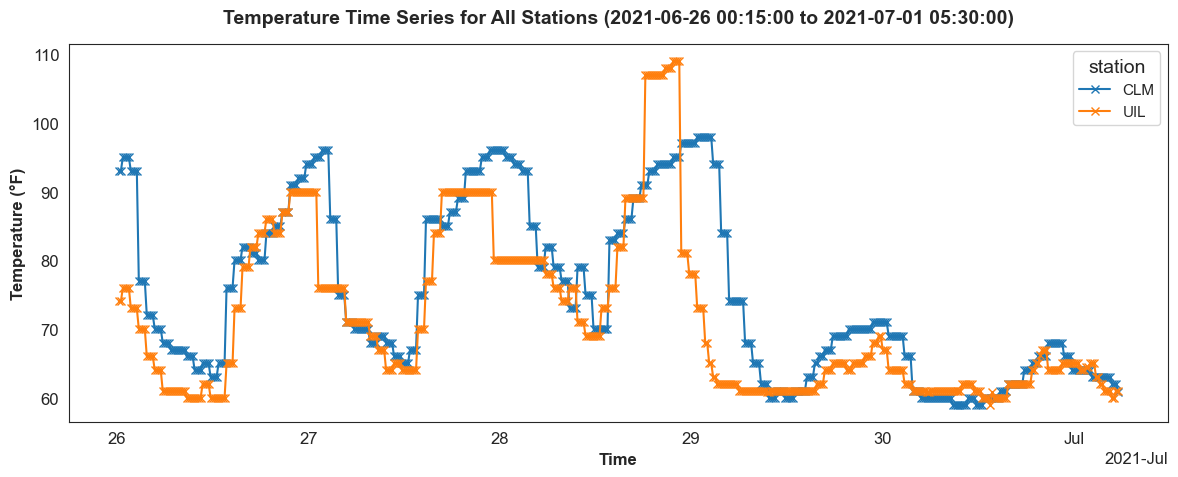

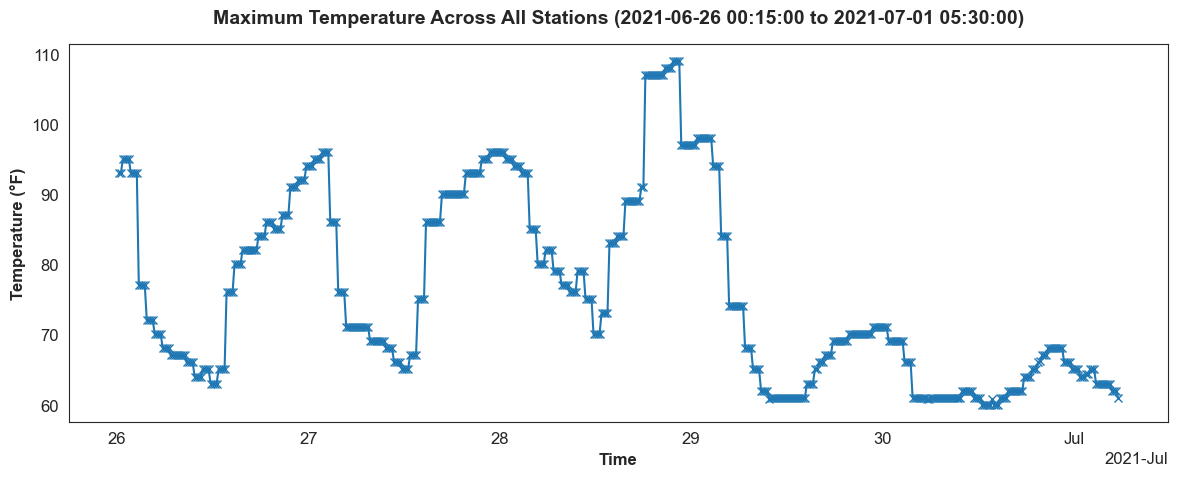

In [20]:
# plot a time series of temperature for all the stations for a given time period
time_from = '2021-06-26 00:15:00'
time_to = '2021-07-01 05:30:00'
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['tmpf'].sel(time=slice(time_from, time_to), station=ds_merged['station']).plot.line(x='time', hue='station', marker='x', ax=ax)
ax.set_title(f'Temperature Time Series for All Stations ({time_from} to {time_to})')
ax.set_ylabel('Temperature (°F)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

# plot a time series of maximum temperature across all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['tmpf'].sel(time=slice(time_from, time_to), station=ds_merged['station']).max(dim='station').plot.line(x='time', marker='x')
ax.set_title(f'Maximum Temperature Across All Stations ({time_from} to {time_to})')
ax.set_ylabel('Temperature (°F)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

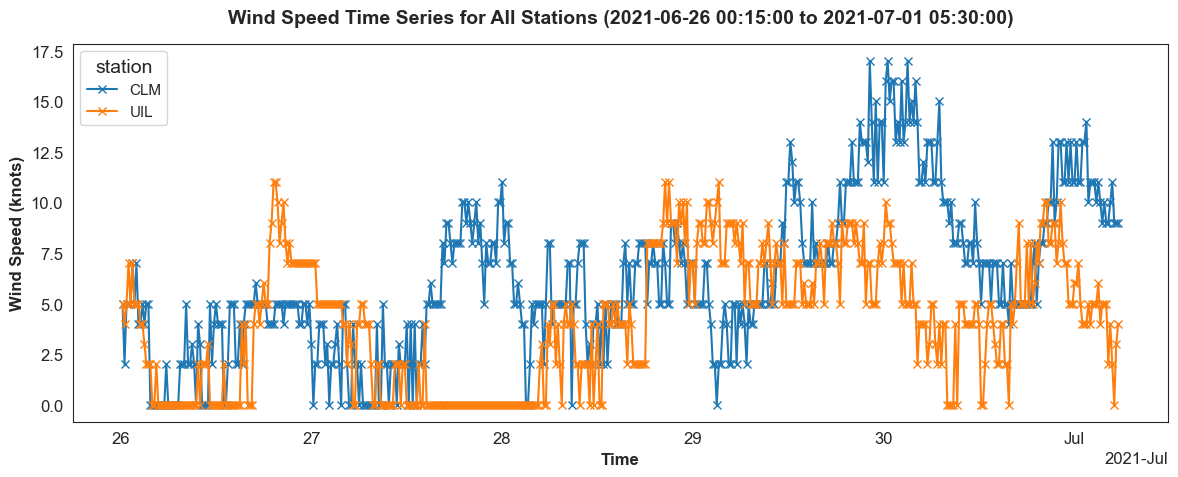

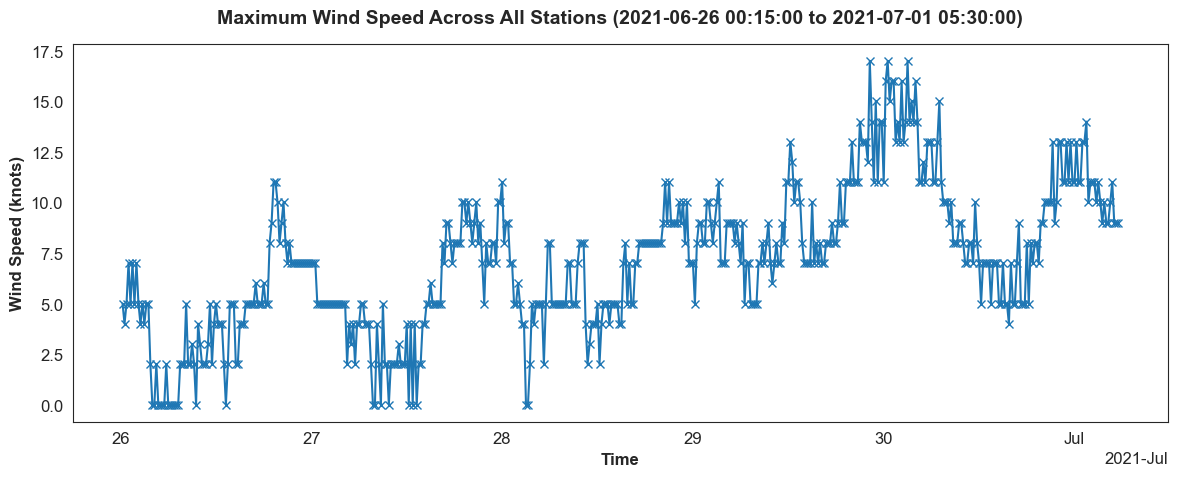

In [21]:
# plot a time series of wind speed for all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['sknt'].sel(time=slice(time_from, time_to), station=ds_merged['station']).plot.line(x='time', hue='station', marker='x', ax=ax)
ax.set_title(f'Wind Speed Time Series for All Stations ({time_from} to {time_to})')
ax.set_ylabel('Wind Speed (knots)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

# plot a time series of maximum wind speed across all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['sknt'].sel(time=slice(time_from, time_to), station=ds_merged['station']).max(dim='station').plot.line(x='time', marker='x')
ax.set_title(f'Maximum Wind Speed Across All Stations ({time_from} to {time_to})')
ax.set_ylabel('Wind Speed (knots)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

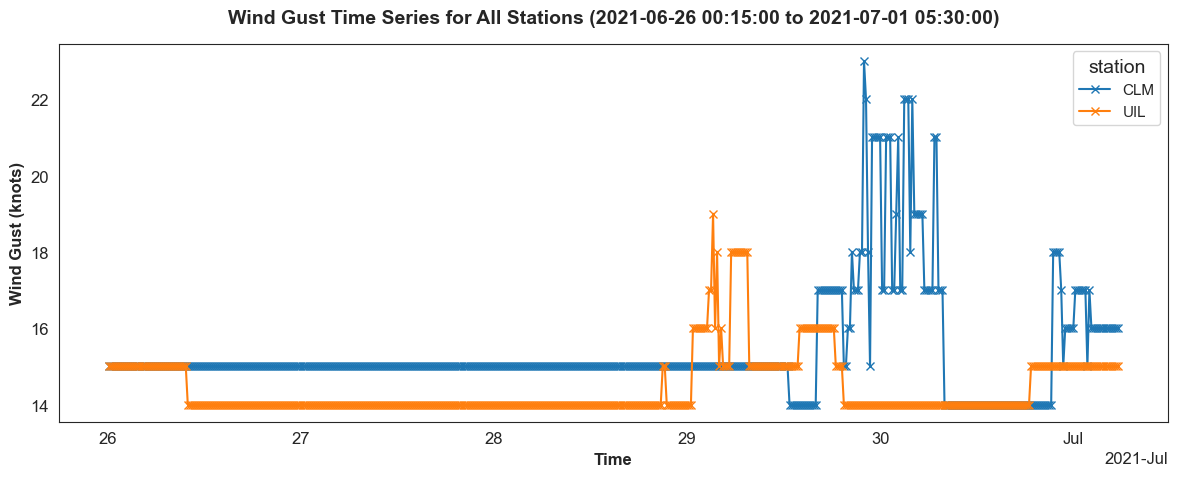

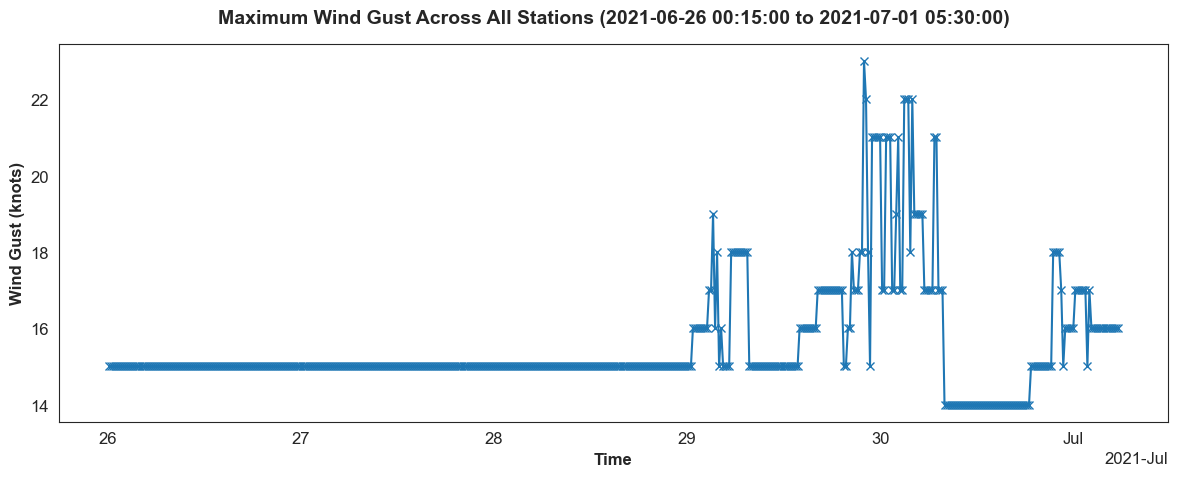

In [22]:
# plot a time series of wind gust for all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['gust'].sel(time=slice(time_from, time_to), station=ds_merged['station']).plot.line(x='time', hue='station', marker='x', ax=ax)
ax.set_title(f'Wind Gust Time Series for All Stations ({time_from} to {time_to})')
ax.set_ylabel('Wind Gust (knots)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

# plot a time series of maximum wind gust across all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['gust'].sel(time=slice(time_from, time_to), station=ds_merged['station']).max(dim='station').plot.line(x='time', marker='x')
ax.set_title(f'Maximum Wind Gust Across All Stations ({time_from} to {time_to})')
ax.set_ylabel('Wind Gust (knots)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

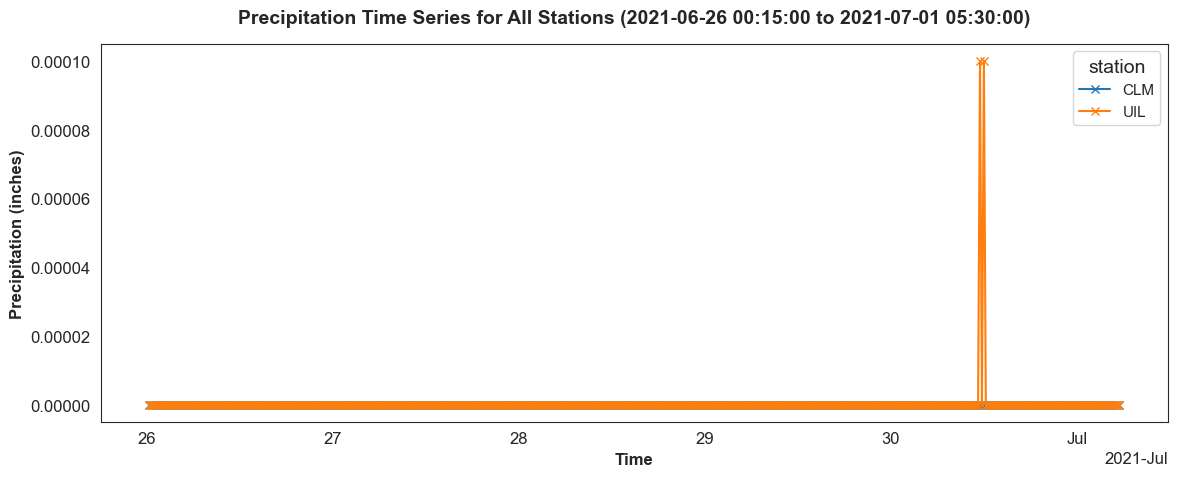

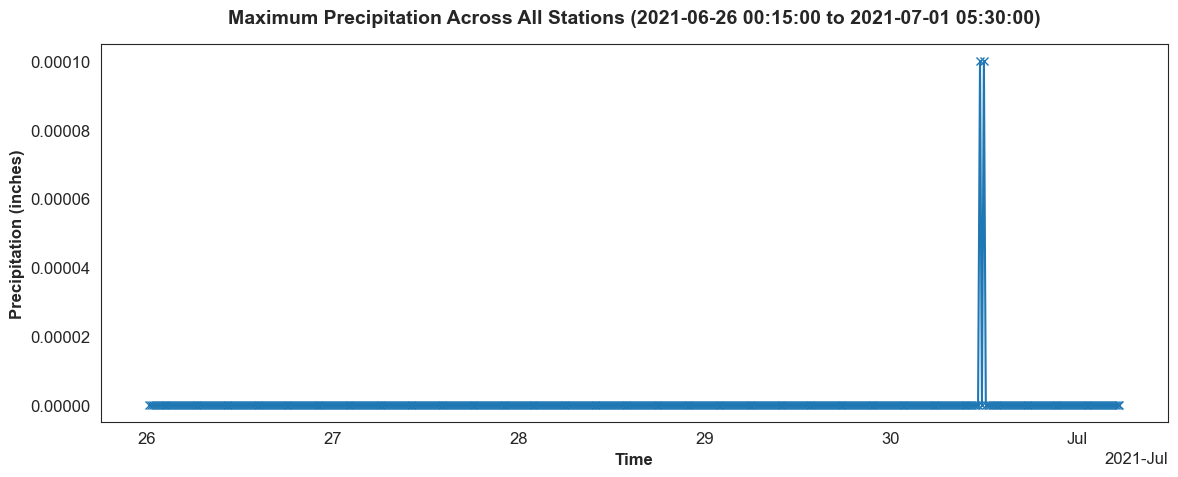

In [23]:
# plot a time series of precipitation for all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['p01i'].sel(time=slice(time_from, time_to), station=ds_merged['station']).plot.line(x='time', hue='station', marker='x', ax=ax)
ax.set_title(f'Precipitation Time Series for All Stations ({time_from} to {time_to})')
ax.set_ylabel('Precipitation (inches)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

# plot a time series of maximum precipitation across all the stations for a given time period
fig, ax = plt.subplots(figsize=(12, 5))
p = ds_merged['p01i'].sel(time=slice(time_from, time_to), station=ds_merged['station']).max(dim='station').plot.line(x='time', marker='x')
ax.set_title(f'Maximum Precipitation Across All Stations ({time_from} to {time_to})')
ax.set_ylabel('Precipitation (inches)')
ax.set_xlabel('Time')
fig.tight_layout()
plt.show()

# Event Statistics

In [56]:
def calculate_events_stats(dataset, event_threshold, station):
    # get a single dataframe merging customers_out, event_number_eaglei and maximum weather variables across all stations
    temp1 = dataset[['customers_out', 'event_number_eaglei']].to_dataframe().reset_index()
    if station == 'all':
        temp2 = dataset[['tmpf', 'sknt', 'gust', 'p01i','poccurence']].max(dim='station').to_dataframe().reset_index()
    else:
        dataset=dataset.sel(station=station)
        temp2 = dataset[['tmpf', 'sknt', 'gust', 'p01i','poccurence']].to_dataframe().reset_index()
    merged_df = pd.merge(temp1, temp2, on='time')

    merged_df_non_zero = merged_df[merged_df['customers_out'] > 0].copy().reset_index()
    event_numbers = merged_df_non_zero.event_number_eaglei.value_counts()[merged_df_non_zero.event_number_eaglei.value_counts()>=event_threshold].index.tolist()

    # import the function to calculate EAGLEi event stats
    from src.eaglei_modules.eagleiEventProcessing import get_eaglei_event_stats
    events_stats = get_eaglei_event_stats(merged_df_non_zero, event_numbers, event_method='eaglei', timestamp_column='time')

    # append weather stats to the events_stats dataframe
    weather_stats_list = []
    for event_num in event_numbers:
        event_data = merged_df_non_zero[merged_df_non_zero['event_number_eaglei'] == event_num]
        weather_stats = {
            'event_number': event_num,
            'max_sknt': event_data['sknt'].max(),
            'min_sknt': event_data['sknt'].min(),
            'avg_sknt': event_data['sknt'].mean(),

            'max_gust': event_data['gust'].max(),
            'min_gust': event_data['gust'].min(),
            'avg_gust': event_data['gust'].mean(),

            'max_tmpf': event_data['tmpf'].max(),
            'min_tmpf': event_data['tmpf'].min(),
            'avg_tmpf': event_data['tmpf'].mean(),

            'total_p01i': event_data['p01i'].sum(),
            'poccurence': event_data['poccurence'].max(),
            'max_p01i': event_data['p01i'].max(),
            'avg_p01i': event_data['p01i'].mean()
        }
        weather_stats_list.append(weather_stats)
    weather_stats_df = pd.DataFrame(weather_stats_list)
    events_stats = pd.merge(events_stats, weather_stats_df, on='event_number', how='left')

    return events_stats

events_stats = calculate_events_stats(ds_merged, event_threshold=30, station='all')

In [57]:
events_stats

,event_number,start_time,end_time,duration_hours,max_customers_out,total_customers_out,num_outages,num_restores,customer_hours,max_sknt,...,max_gust,min_gust,avg_gust,max_tmpf,min_tmpf,avg_tmpf,total_p01i,poccurence,max_p01i,avg_p01i
0,1580,2023-01-25 23:30:00,2023-02-05 23:30:00,264.00,24,88,31,20,745.75,21.0,...,41.0,15.0,18.599432,52.0,24.1,43.035038,5.984900,1.0,0.22,0.005668
1,76,2019-08-13 16:00:00,2019-08-23 16:15:00,240.25,6,11,6,6,475.75,16.0,...,22.0,14.0,16.655567,77.0,49.0,61.970654,2.532200,1.0,0.14,0.002635
2,1575,2023-01-09 17:15:00,2023-01-16 20:45:00,171.50,16,33,17,14,703.50,23.0,...,43.0,14.0,18.676384,56.0,39.0,48.333523,19.664900,1.0,0.28,0.028666
3,1261,2022-07-27 17:00:00,2022-08-01 22:15:00,125.25,24,30,14,9,2717.25,11.0,...,16.0,14.0,14.632734,82.0,54.0,65.322556,0.000000,0.0,0.00,0.000000
4,889,2021-12-13 10:15:00,2021-12-18 14:30:00,124.25,10,37,26,16,515.75,16.0,...,31.0,15.0,17.058350,48.0,34.0,39.538834,11.604799,1.0,0.53,0.023350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,554,2021-05-03 15:45:00,2021-05-03 23:15:00,7.50,3,3,2,1,19.00,8.0,...,16.0,16.0,16.000000,53.0,50.0,51.799999,0.260400,1.0,0.04,0.008680
654,1767,2023-06-15 07:30:00,2023-06-15 15:00:00,7.50,1,1,1,1,7.50,9.0,...,18.0,18.0,18.000000,54.0,52.0,52.900002,0.000000,0.0,0.00,0.000000
655,1208,2022-07-02 08:00:00,2022-07-02 15:30:00,7.50,17,17,3,3,109.50,11.0,...,17.0,15.0,15.933333,57.0,54.0,55.133335,0.000000,0.0,0.00,0.000000
656,2791,2024-12-18 15:45:00,2024-12-18 23:15:00,7.50,19,24,7,7,47.75,14.0,...,22.0,22.0,22.000000,53.0,50.0,51.366665,0.050200,1.0,0.01,0.001673


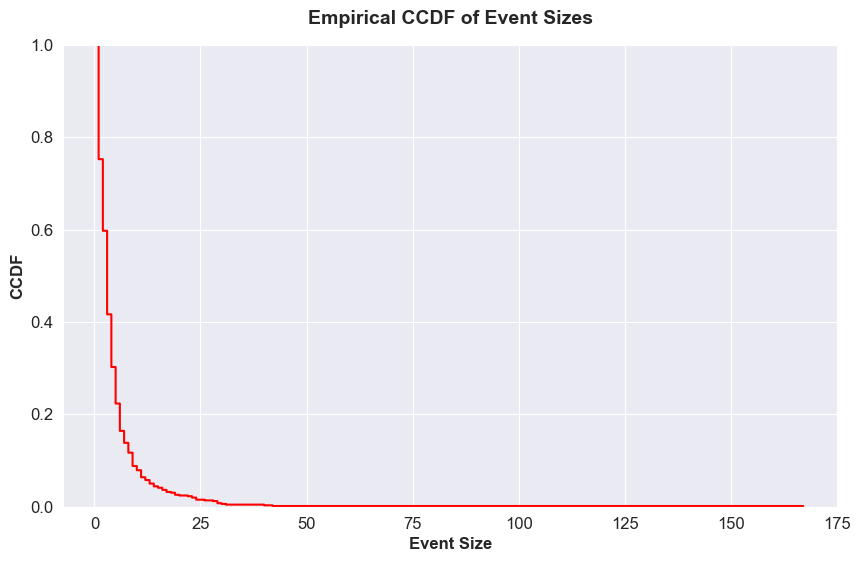

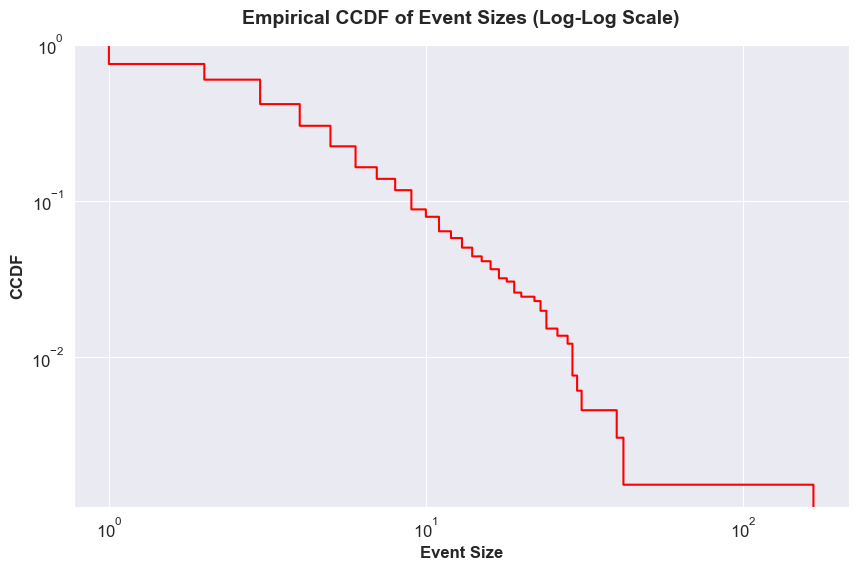

In [58]:
# create an empirical ccdf of event sizes
sns.ecdfplot(data=events_stats, x='num_outages', complementary=True, color='red')
plt.xlabel('Event Size')
plt.ylabel('CCDF')
plt.title('Empirical CCDF of Event Sizes')
plt.show()

sns.ecdfplot(data=events_stats, x='num_outages', complementary=True, log_scale=True, color='red')
plt.xlabel('Event Size')
plt.ylabel('CCDF')
plt.yscale('log')
plt.title('Empirical CCDF of Event Sizes (Log-Log Scale)')
plt.show()

[ 6.58097089  0.07930856 -3.45573386]


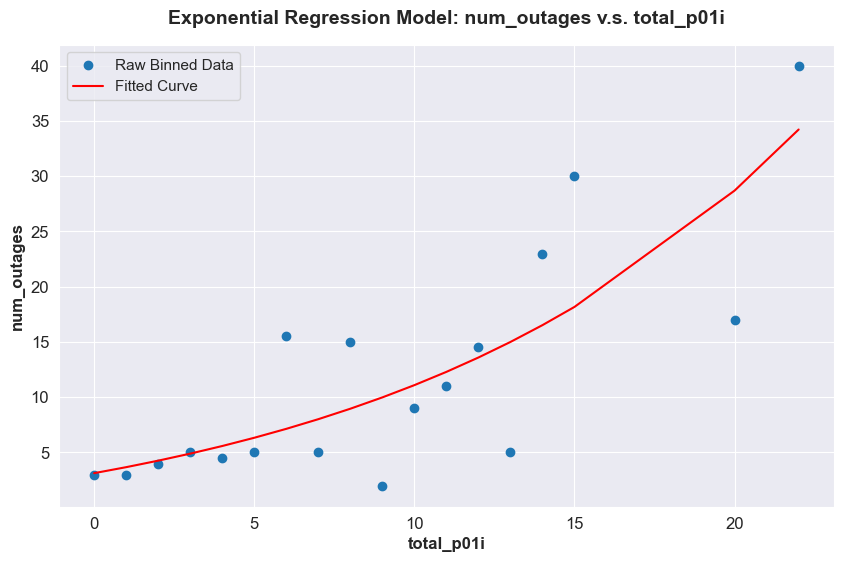

In [59]:
# Basic Exponential Regression Model of Weather-Outage Relationship

from scipy.optimize import curve_fit

# Function to fit
def exponential_function(x,a,b,c):
    return a * np.exp(b*x) + c

def myround(x, base):
    return base * round(x/base)

weather_variable='total_p01i'
outage_variable='num_outages'

events_stats[weather_variable]=myround(events_stats[weather_variable],1)
# average all outage instances over their target weather variable
df_grouped = events_stats.groupby(weather_variable).agg({
    outage_variable: 'median'
}).reset_index()

# filter out anomalous weather variables that we do not have data to analyze
#df_grouped = df_grouped[df_grouped[weather_variable] >80]

# Raw Data
x = df_grouped[weather_variable].values
y = df_grouped[outage_variable].values
plt.scatter(x,y,label='Raw Binned Data')
#yscale('log')

# Fitted Data - May have to change p0 to fit the data
popt,pcov = curve_fit(exponential_function,x,y,p0=[10, 0.05, 0],maxfev=20000)
print(popt)
plt.plot(df_grouped[weather_variable], exponential_function(df_grouped[weather_variable], *popt), 'r-', label="Fitted Curve")

# Plot Settings
plt.title(f"Exponential Regression Model: {outage_variable} v.s. {weather_variable}")
plt.xlabel(f'{weather_variable}')
plt.ylabel(f'{outage_variable}')
plt.legend()
plt.grid(True)
plt.show()

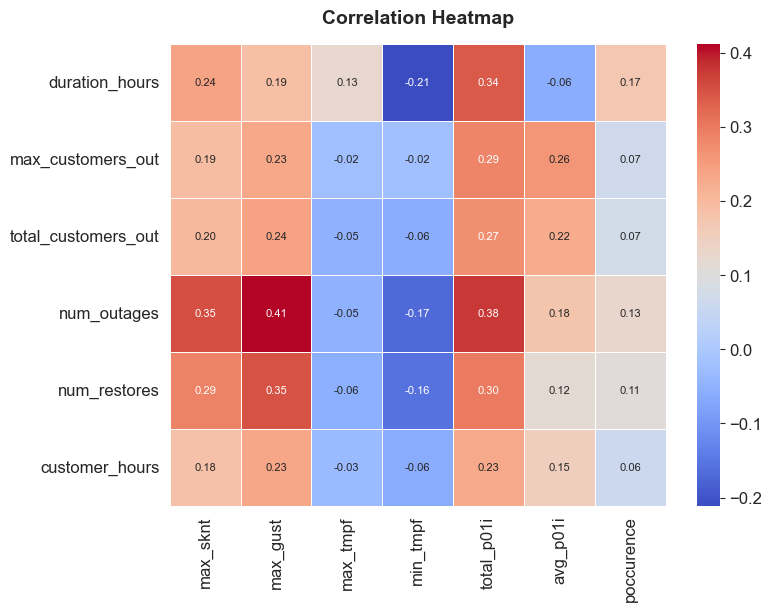

In [60]:
# Create correlation matrix between features in event_stats

x_cols=['max_sknt','max_gust','max_tmpf','min_tmpf','total_p01i','avg_p01i','poccurence']
y_cols=['duration_hours','max_customers_out','total_customers_out','num_outages','num_restores','customer_hours']

corr=events_stats[x_cols+y_cols].corr()

matrix=corr.loc[y_cols,x_cols]

plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 8},linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()